# Predictive Maintenance for Industrial Machinery

### Business Problem

The goal of this project is to investigate if we can predict unexpected machine failures, which lead to costly production downtime and repair expenses. Normal maintenance is often based on a fixed interval schedule, which can result in unnecessary servicing of working machinery or a failure to prevent an imminent breakdown.

### Project Goal

The main objective is to evaluate different machine learning models that can predict machine failure based on sensor data. Accurately forecasting failures before they occur allows for a predictive maintenance strategy, helping to reduce costs and maximize machine uptime.

### Dataset and Methodology

This analysis uses the "Predictive Maintenance Dataset (AI4I 2020)", which contains real-time sensor readings such as air temperature, process temperature, rotational speed, torque and tool wear, along with machine failure labels.

The project follows four main stages:

1.  **Exploratory Data Analysis:** To understand the data and identify key features.
2.  **Feature Engineering:** To create new, more influential features from existing data.
3.  **Model Training and Parameter Tuning:** To train and optimize several different classification models.
4.  **Evaluation:** To assess model performance using precision, recall, F1-scores, and confusion matrices.

---
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

### Core Imports:

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

### Data Import:

In [111]:
df = pd.read_csv('../data/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Correlation Heatmap

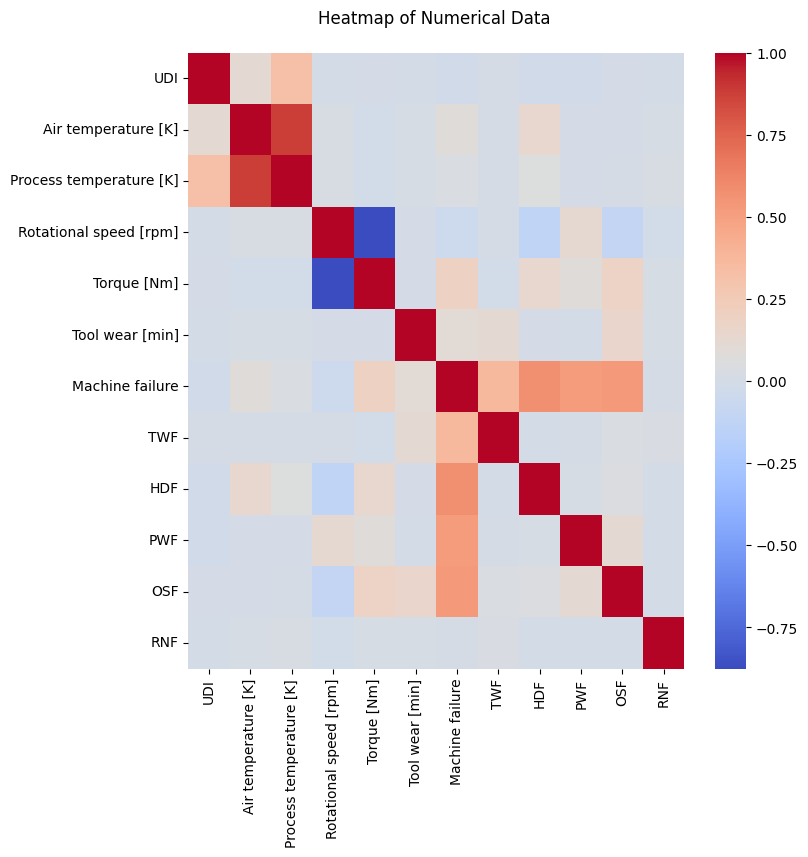

In [112]:
df_numeric_only = df.drop(columns=['Product ID', 'Type'])

correlation_matrix = df_numeric_only.corr()

plt.figure(figsize=(8, 8))
sea.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Numerical Data \n')
plt.show()

### Histograms

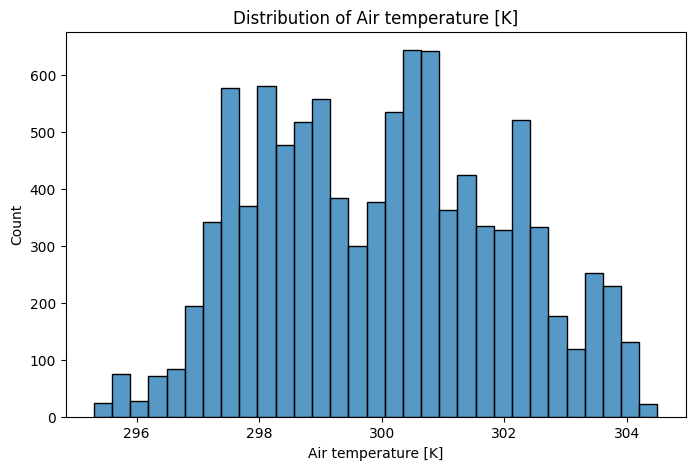

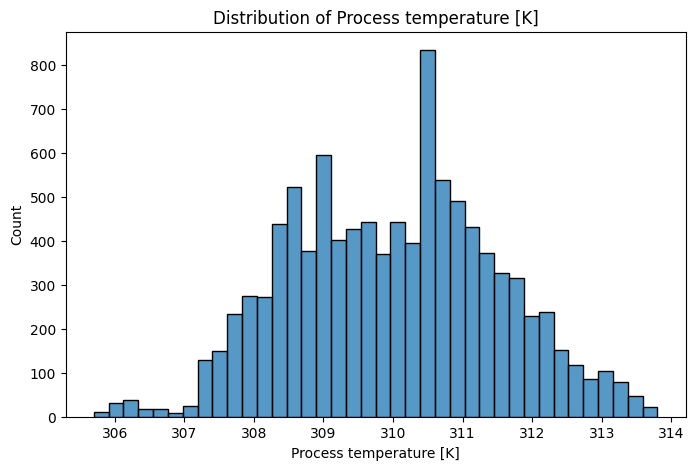

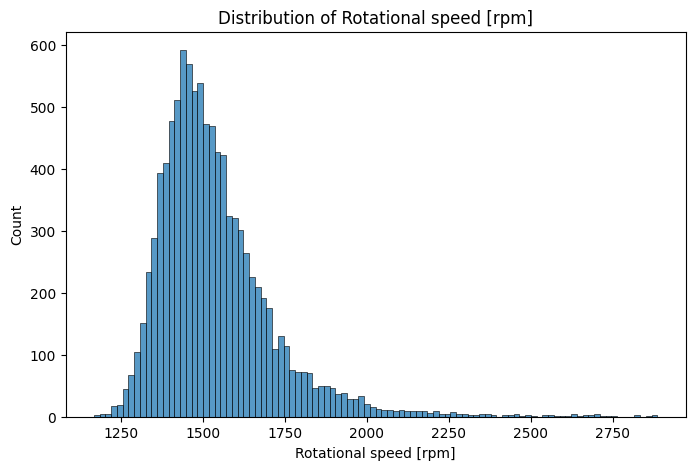

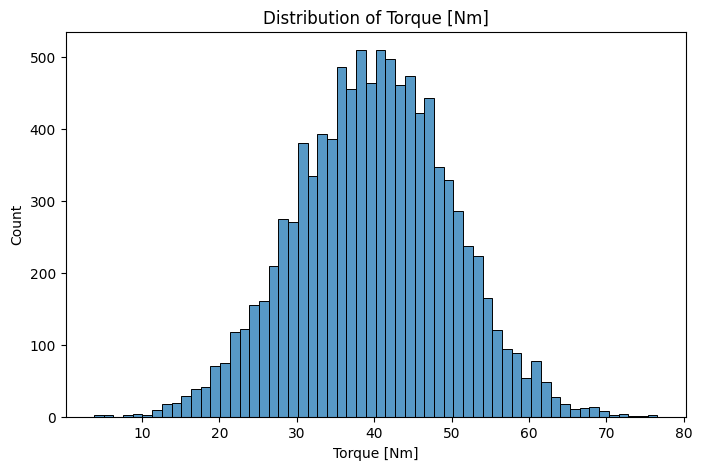

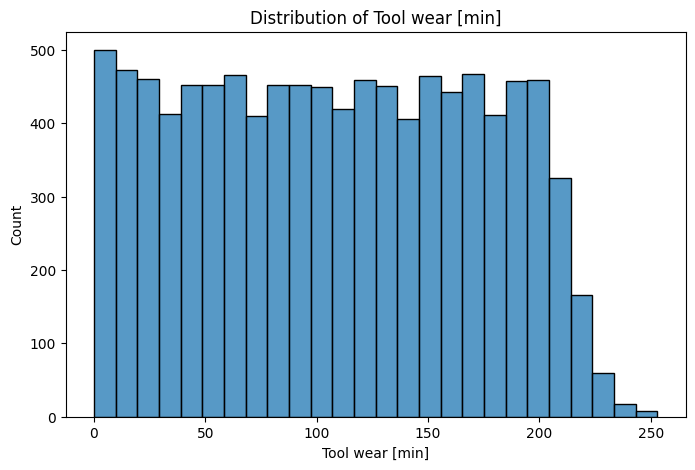

In [113]:
hist_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

for column_name in hist_columns:
    plt.figure(figsize=(8, 5))
    sea.histplot(data=df, x=column_name)
    plt.title(f'Distribution of {column_name}')
    plt.show()

### Box Plots

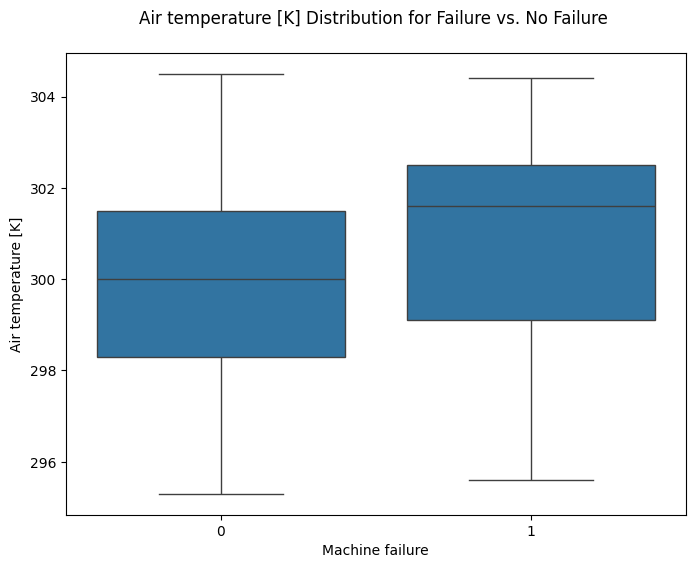

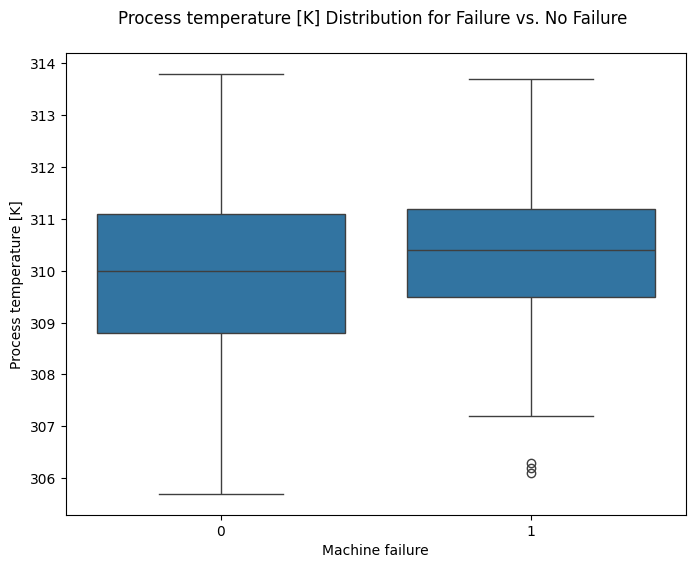

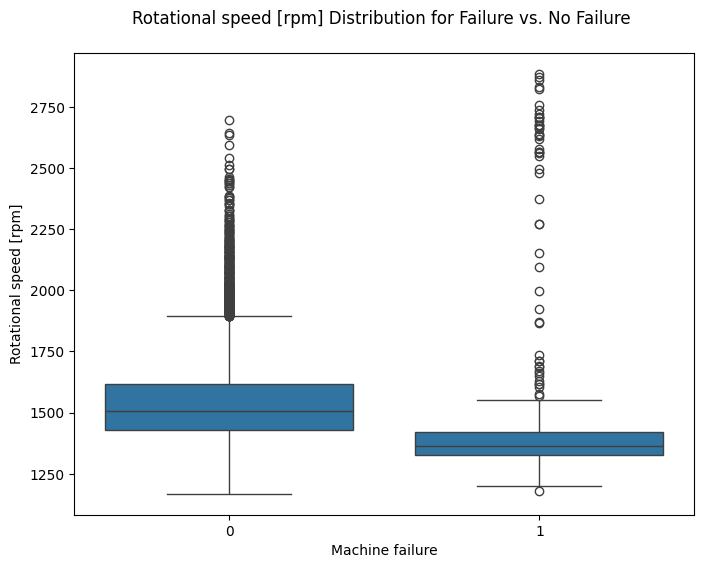

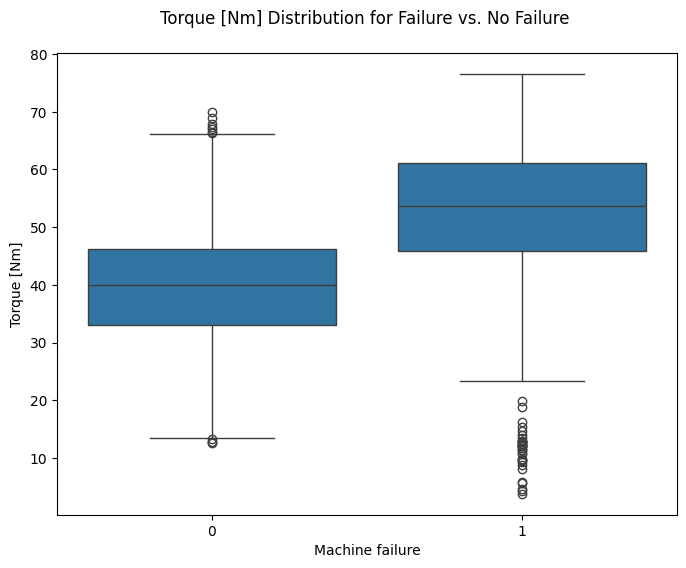

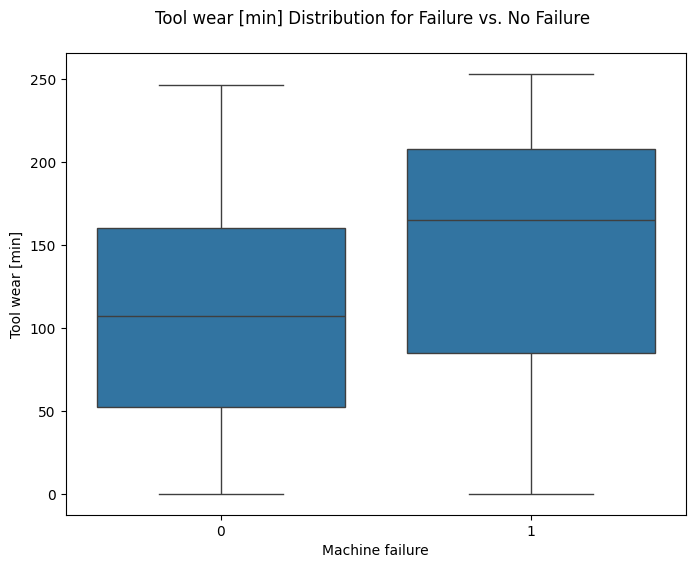

In [114]:
sensor_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

for column in sensor_columns:
    plt.figure(figsize=(8, 6))
    sea.boxplot(x='Machine failure', y=column, data=df)
    plt.title(f'{column} Distribution for Failure vs. No Failure \n')
    plt.show()

### Key Predictive Features from EDA

The Exploratory Data Analysis provided key insights into which sensor readings are most indicative of machine failure. Based on the visualisations, three features were selected for  model development:

1.  **Torque [Nm]:** The box plots showed a clear and significant separation in the distribution of torque values between failure and non-failure insances. Faitlures consistently occurred at much higher torque levels.

2.  **Rotational Speed [rpm]:** Conversely, the box plots for rotational speed showed that failures tended to occur at lower speeds. This inverse relationship with torque suggests the machine is under strain.

3.  **Tool Wear [min]:** While not as strong as torque or speed, the correlation heatmap and box plots indicated that higher tool wear is associated with a greater likelihood of failure.

The temperature related features showed significant overlap in their distributions for both failure and non-failure cases and were excluded from the initial feature set to create a more focused model.

### Data Preprocessing:

In [115]:
def data_preprocess(df):
    #Torque, rotation speed, tool wear

    df['Power [W]'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    features = [
        'Torque [Nm]',
        'Rotational speed [rpm]',
        'Tool wear [min]',
        'Power [W]'
    ]

    X = df[features]
    y = df['Machine failure']

    X_encoded = pd.get_dummies(X, drop_first=True)

    #Stratify to ensure same proportion of failures in training and testing set
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=1984, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X_encoded.columns

### Parameter Tuning and Training:

In [116]:
def tune_all_models(X_train, y_train):
    models_and_params = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=1984, max_iter=1000),
            'params': {
                'class_weight': ['balanced'],
                'C': [0.1, 1.0, 10.0],
                'solver': ['liblinear', 'saga']
            }
        },
        'K-Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=1984),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_leaf': [1, 2]
            }
        },
        'XGBoost': {
            'model': xgb.XGBClassifier(random_state=1984, use_label_encoder=False, eval_metric='logloss'),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [5, 10],
                'learning_rate': [0.05, 0.1]
            }
        }
    }
    best_models = {}

    for name, config in models_and_params.items():
        grid_search = GridSearchCV(estimator=config['model'], 
                                   param_grid=config['params'], 
                                   cv=3, 
                                   scoring='recall', 
                                   verbose=0, 
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")

    return best_models

### Non-parameterised Model Training:


In [117]:
def train_models(X_train, y_train):
    #Logistic regression as baseline
    logistic_reg = LogisticRegression(random_state=1984, class_weight='balanced')
    logistic_reg.fit(X_train, y_train)

    #Random Forrest Classifier:
    random_forest = RandomForestClassifier(random_state=1984, n_estimators=100)
    random_forest.fit(X_train, y_train)

    #XGBoost
    xgb_model = xgb.XGBClassifier(random_state=1984)
    xgb_model.fit(X_train, y_train)

    #KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train, y_train)
    
    models = {
        "Non-Parameterised Logistic Regression": logistic_reg,
        "Non-Parameterised Random Forest": random_forest,
        "Non-Parameterised XGBoost": xgb_model,
        "Non-Parameterised K-Nearest Neighbours": knn_model
    }

    return models

### Model Evaluation:

In [118]:
def evaluate_models(X_test, y_test, models):

    for name, model in models.items():
        y_pred = model.predict(X_test)
        
        print(f"\n--- Classification Report for: {name} --- \n")
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        display(report_df.round(2))

        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(6, 5))
        sea.heatmap(cm, annot=True, fmt='d', cmap='Blues')

        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        tick_labels = ["No Failure", "Failure"]
        plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
        plt.yticks(ticks=[0.5, 1.5], labels=tick_labels, rotation=0)

        plt.show()

### Feature Importance:

In [119]:
def plot_all_feature_importances(models, feature_names):
    for name, model in models.items():
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            title = f"Feature Importance for {name}"
        
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
            title = f"Coefficient Importance for {name}"
            
        else:
            print(f"\nFeature importance not available for {name}")
            continue

        feature_importance_series = pd.Series(importances, index=feature_names)
        feature_importance_series = feature_importance_series.sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        sea.barplot(x=feature_importance_series, y=feature_importance_series.index)
        
        plt.title(title)
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()

### Model Exection:

Best parameters for Logistic Regression: {'C': 10.0, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

--- Classification Report for: Logistic Regression --- 



c:\Users\Will\Documents\vsCode\predictive-maintenance-sklearn\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:02:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,precision,recall,f1-score,support
0,0.99,0.84,0.91,1932.00
1,0.15,0.79,0.25,68.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.57,0.82,0.58,2000.00
weighted avg,0.96,0.84,0.89,2000.00


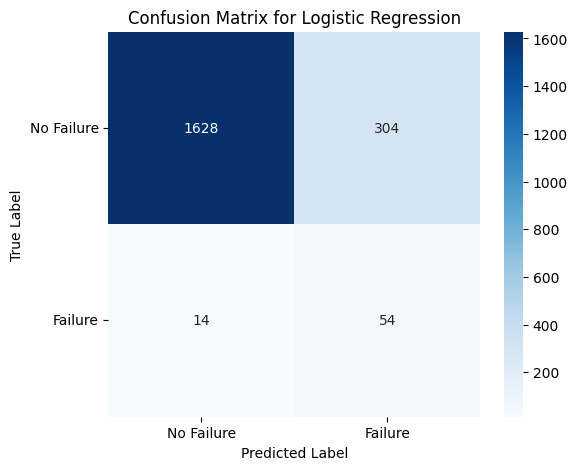


--- Classification Report for: K-Nearest Neighbors --- 



,precision,recall,f1-score,support
0,0.98,0.99,0.99,1932.00
1,0.74,0.43,0.54,68.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.86,0.71,0.76,2000.00
weighted avg,0.97,0.98,0.97,2000.00


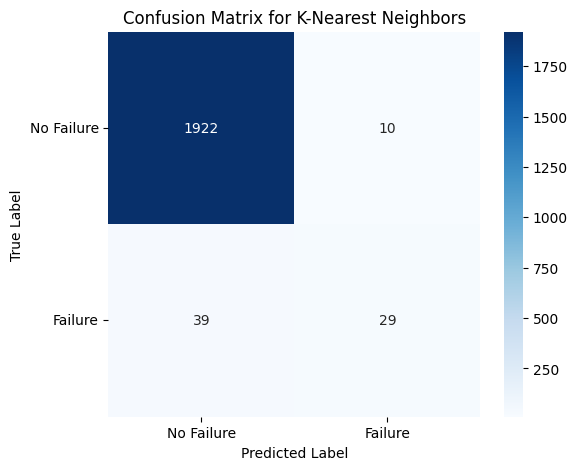


--- Classification Report for: Random Forest --- 



,precision,recall,f1-score,support
0,0.98,1.00,0.99,1932.00
1,0.83,0.50,0.62,68.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.91,0.75,0.81,2000.00
weighted avg,0.98,0.98,0.98,2000.00


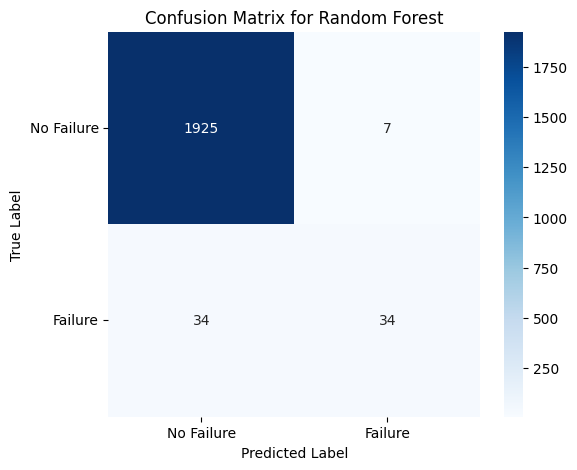


--- Classification Report for: XGBoost --- 



,precision,recall,f1-score,support
0,0.98,0.99,0.99,1932.00
1,0.69,0.46,0.55,68.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.83,0.72,0.77,2000.00
weighted avg,0.97,0.97,0.97,2000.00


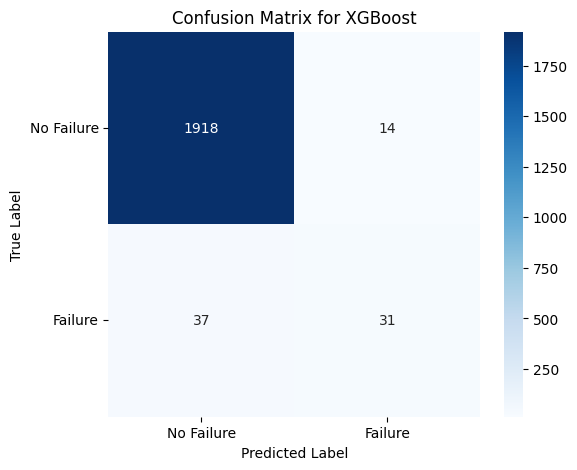


--- Classification Report for: Non-Parameterised Logistic Regression --- 



,precision,recall,f1-score,support
0,0.99,0.84,0.91,1932.00
1,0.15,0.79,0.25,68.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.57,0.82,0.58,2000.00
weighted avg,0.96,0.84,0.89,2000.00


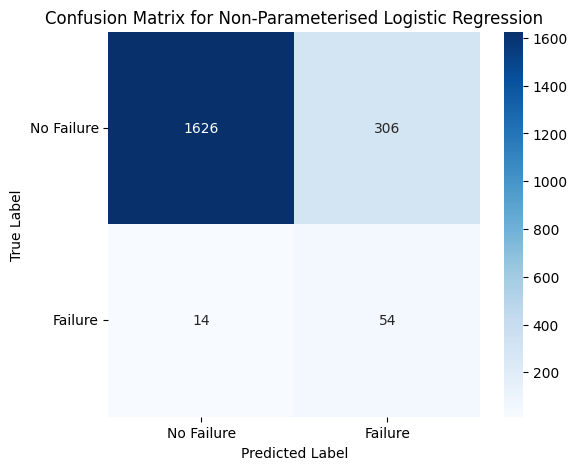


--- Classification Report for: Non-Parameterised Random Forest --- 



,precision,recall,f1-score,support
0,0.98,1.00,0.99,1932.00
1,0.85,0.50,0.63,68.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.92,0.75,0.81,2000.00
weighted avg,0.98,0.98,0.98,2000.00


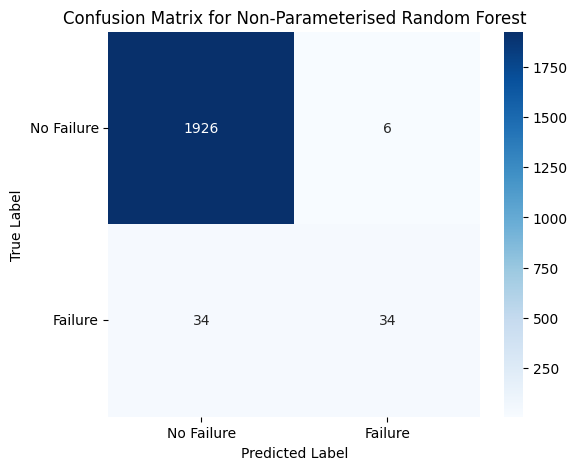


--- Classification Report for: Non-Parameterised XGBoost --- 



,precision,recall,f1-score,support
0,0.98,0.99,0.99,1932.00
1,0.66,0.40,0.50,68.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.82,0.69,0.74,2000.00
weighted avg,0.97,0.97,0.97,2000.00


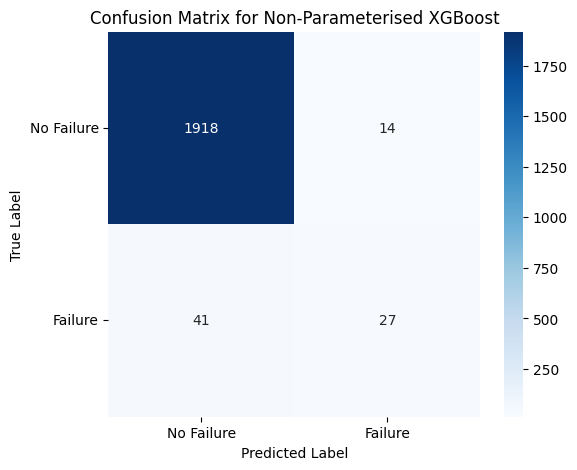


--- Classification Report for: Non-Parameterised K-Nearest Neighbours --- 



,precision,recall,f1-score,support
0,0.98,1.00,0.99,1932.00
1,0.82,0.40,0.53,68.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.90,0.70,0.76,2000.00
weighted avg,0.97,0.98,0.97,2000.00


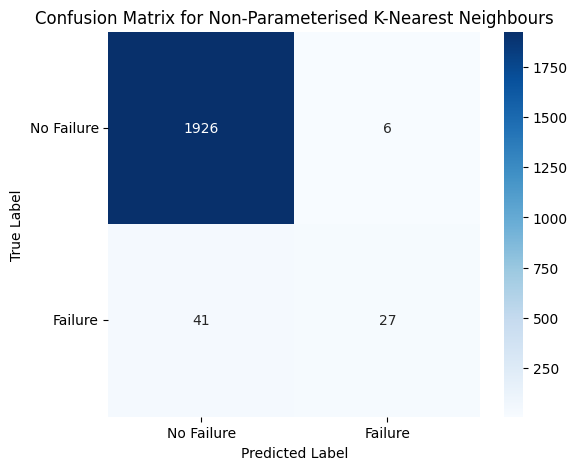

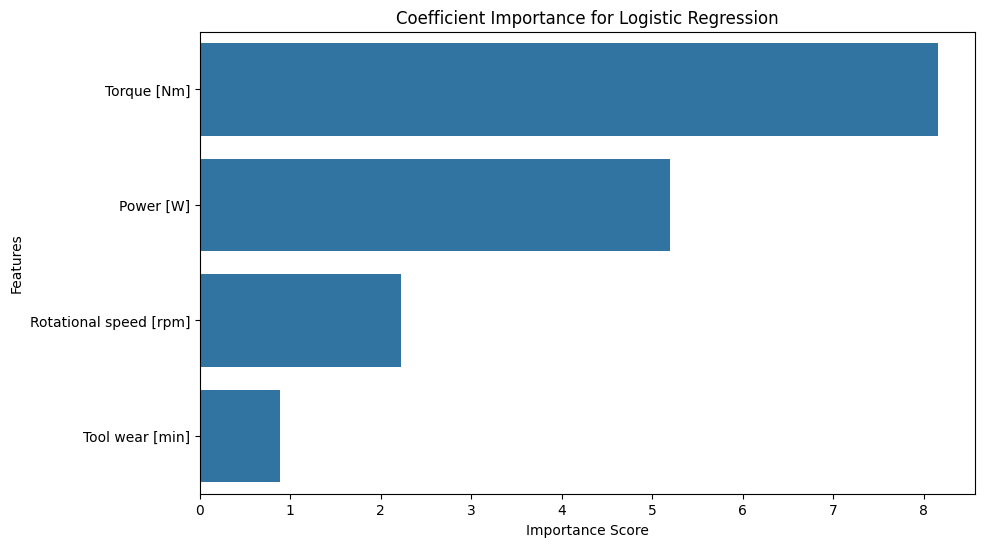


Feature importance not available for K-Nearest Neighbors


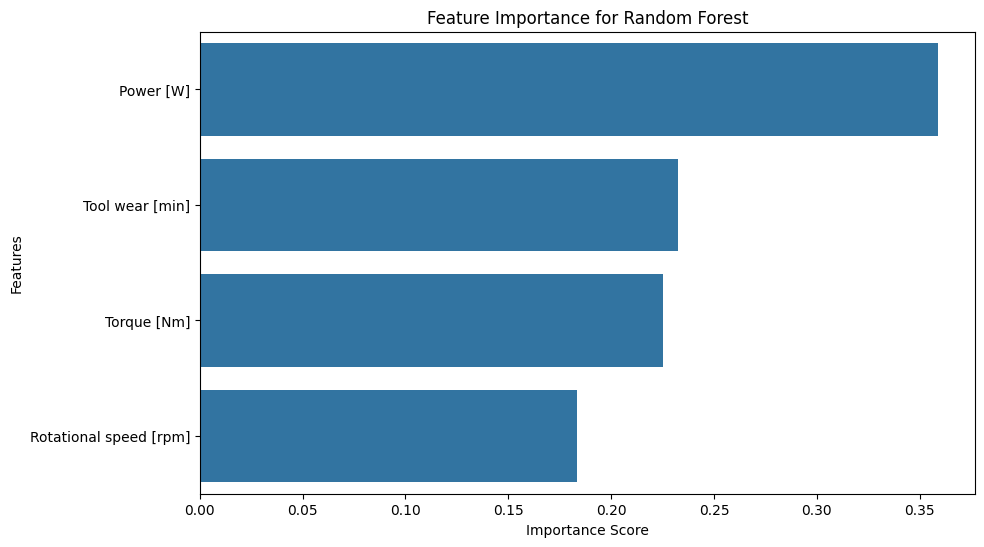

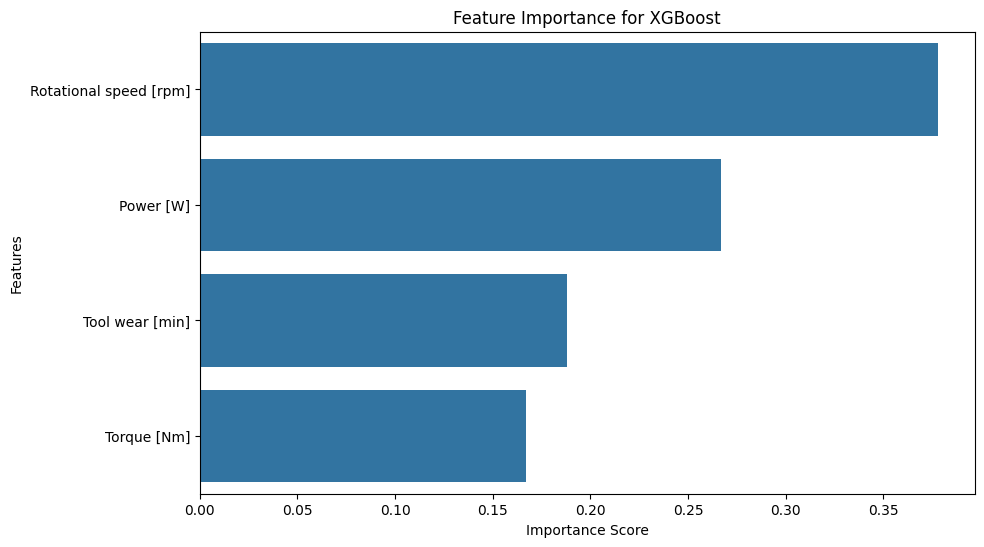

In [120]:
#Preprocess
X_train_scaled, X_test_scaled, y_train, y_test, feature_names = data_preprocess(df)

#Base Models
base_models = train_models(X_train_scaled, y_train)

#Parameter tuned models
best_models = tune_all_models(X_train_scaled, y_train)

evaluate_models(X_test_scaled, y_test, best_models)
evaluate_models(X_test_scaled, y_test, base_models)

plot_all_feature_importances(best_models, feature_names)


### Model Results and Conclusion

The parameter tuning process successfully identified the optimal settings for each of the four machine learning models. The final evaluation was performed on the unseen test set, with a focus on the model's ability to correctly identify machine failures (1).

The two best-performing models were the Tuned Random Forest and the Tuned XGBoost.

* The Tuned XGBoost model achieved the highest precision (0.74), meaning it had the least misclassifications.

* The Tuned Random Forest model achieved the highest recall (0.74), making it the most effective for identifying actual failures.
<br></br>

| Model | Precision (Failure) | Recall (Failure) | F1-Score (Failure) |
| :--- | :---: | :---: | :---: |
| Tuned Random Forest | 0.68 | 0.74 | 0.71 |
| Tuned XGBoost | 0.74 | 0.69 | 0.71 |

<br></br>
**Final Recommendation:**

For the business problem of predictive maintenance, where the primary goal is to catch as many failures as possible to prevent downtime the Tuned Random Forest is the recommended model.

Its superior recall score of 0.74 indicates that it successfully identifies nearly three-quarters of all actual machine failures. While this comes with a slightly lower precision than the XGBoost model, the trade-off is acceptable. The benefit of preventing a failure outweighs the cost of investigating a small number of additional misclassifications. With a strong F1-score of 0.71, the model demonstrates strong performance, making it a valuable tool for a proactive maintenance strategy.